# QDrift

In [1]:
from trotter.hamsimtrotter import AlgorithmHamSimTrotter
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=10, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg

    t_max=2
    seg = N
    initial_state_circ = Circuit(n)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Expectation

In [2]:
# gen_sys_param()
# n_qdrift_steps = 100
# drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
# drift_time_evolution.Drift_exp()
# trotter_time_evolution_cheat = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
# trotter_time_evolution_cheat._trotter_step_cheat(exps='Energy')
# drift_time_evolution.execute(list(trotter_time_evolution_cheat._real_measurement.values()), color='purple')

# Error bound

In [3]:
# gen_sys_param()
# error = 1
# n_qdrift_steps = 3
# while error > 1e-4:
#     U_sims = []
#     gen_sys_param()
#     time_evolution = AlgorithmHamSimqDrift(initial_state_circ,Heisenberg_d,Heisenberg_c,Heisenberg[0],t_max,n_qdrift_steps,t)
#     time_evolution.Drift_exp()
#     U_sim = time_evolution.execute()
#     U_sims.append(U_sim)
#     trotter_time_evolution = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_qdrift_steps,t)
#     U = trotter_time_evolution.execute(color='green', cheat=False, plot=False)
#     error = calculate_error(U_sims, U)
#     print('step:',n_qdrift_steps,'error:',error)
#     if error < precision:
#         print('Congratulations!')
#     n_qdrift_steps *= 10

'''
step: 3 error: 1.8507102429864286
step: 30 error: 1.749055560834051
step: 300 error: 1.300882374374903
step: 3000 error: 0.7472272607324455
step: 30000 error: 0.1812082026023719
step: 300000 error: 0.059744391798576615
'''

'\nstep: 3 error: 1.8507102429864286\nstep: 30 error: 1.749055560834051\nstep: 300 error: 1.300882374374903\nstep: 3000 error: 0.7472272607324455\nstep: 30000 error: 0.1812082026023719\nstep: 300000 error: 0.059744391798576615\n'

# Term grouping

In [4]:
H_matrix, ops_dict, ops2, H_ops_orig, H_coeff_orig = generate_dict(LiH())
min_clique_cover = create_clique(ops2, ops_dict)
H_coeff = []
for i,clique in enumerate(min_clique_cover):
    H_coeff.append([])
    for op in clique:
        H_coeff[i].append(ops_dict[op])

In [5]:
gen_sys_param(sample_steps = 5)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,min_clique_cover,H_coeff,t_max,n_qdrift_steps)
particle_no, idx = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [6]:
dict_term = {paulistr: count for paulistr, count in zip([get_dict_str(min_clique_cover[id][0]) for id in list(set(list(idx)))], [list(idx).count(i) for i in list(set(list(idx)))])}

TypeError: unhashable type: 'list'

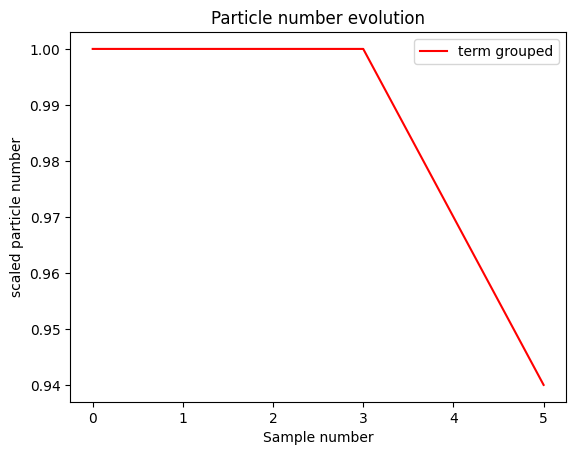

In [ ]:
particle_number(np.arange(6),particle_no, label='term grouped', color='r')

In [ ]:
gen_sys_param(sample_steps = drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
particle_no_orig, idx_orig = drift_time_evolution_orig.Drift_exp()

In [ ]:
dict_orig = {paulistr: count for paulistr, count in zip([get_dict_str(list(ops_dict.keys())[id]) for id in list(set(list(idx_orig)))], [list(idx_orig).count(i) for i in list(set(list(idx_orig)))])}

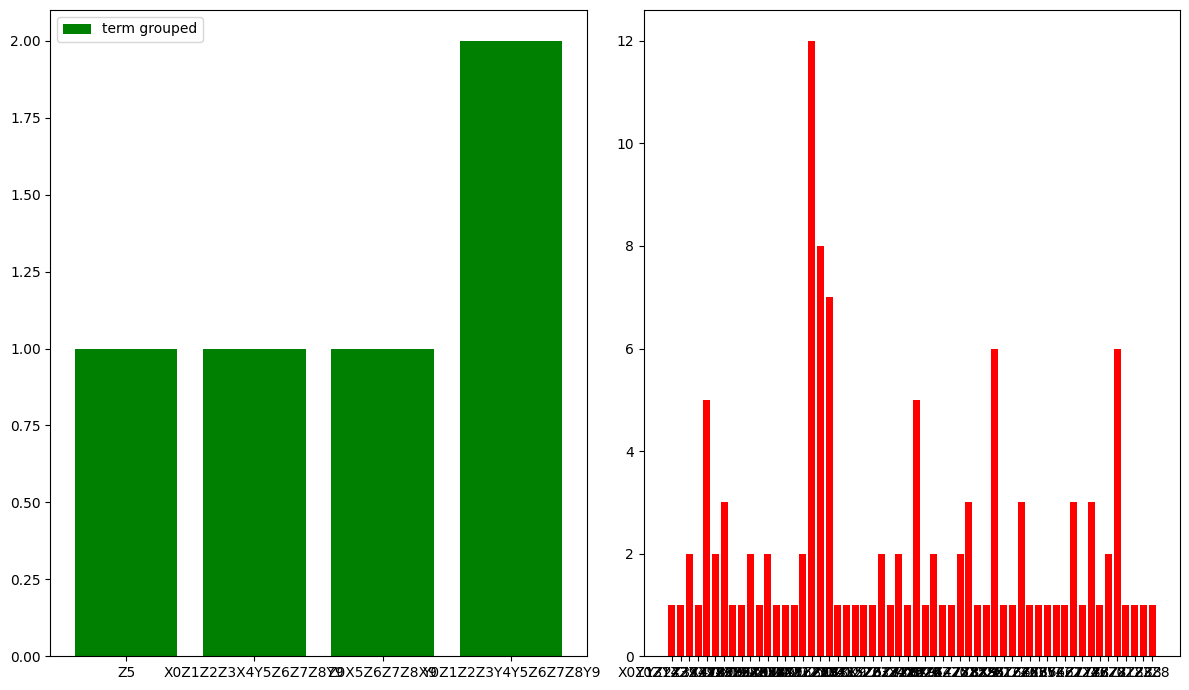

In [ ]:
hist([dict_term, dict_orig])

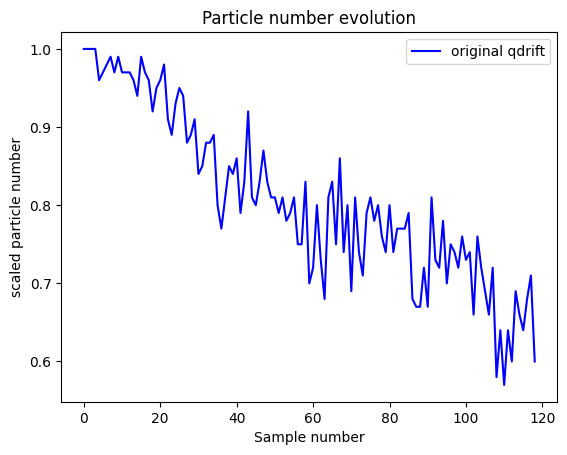

In [ ]:
particle_number(sample_space,particle_no_orig, label='original qdrift', color='b')

In [ ]:
# compare spectral error
gen_sys_param(sample_steps = 10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,min_clique_cover,H_coeff,t_max,n_qdrift_steps)
Us, V = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [ ]:
gen_sys_param(sample_steps=drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
Us_orig, _ = drift_time_evolution_orig.Drift_exp()
Us_orig = section(V,Us_orig)

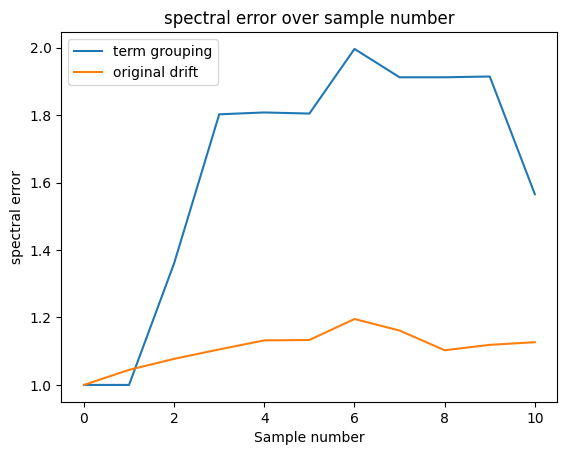

In [ ]:
gen_sys_param(sample_steps = 10)
U = U_exc(drift_time_evolution._initial_state,n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, U, Us, Us_orig)

# Particle number grouping

In [ ]:
particle_group_coeff = list(set(list(ops_dict.values())))
p_coeff = [[co] for co in particle_group_coeff]
particle_group = []
for coeff in particle_group_coeff:
    particle_group.append([]) 
    for strs in list(ops_dict.keys()):
        if ops_dict[strs]==coeff:
            particle_group[particle_group_coeff.index(coeff)].append(strs) 

In [ ]:
gen_sys_param(sample_steps = 10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,particle_group,p_coeff,t_max,n_qdrift_steps)
Us, V = drift_time_evolution.Drift_exp(track_no_paulistr=True)

In [ ]:
def section(term_list, Us_orig):
    U = [Us_orig[0]]
    count = 0
    for i in range(len(term_list)):
        count += len(term_list[i])
        U.append(Us_orig[count])
    return U

In [ ]:
gen_sys_param(sample_steps = drift_time_evolution.terms)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
Us_orig, _ = drift_time_evolution_orig.Drift_exp()
Us_orig = section(V,Us_orig)

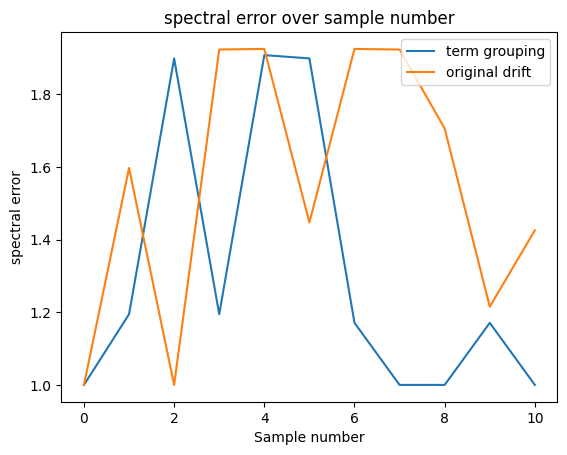

In [ ]:
gen_sys_param(sample_steps = 10)
U = U_exc(drift_time_evolution._initial_state,n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, U, Us, Us_orig)

# Heisenberg group

In [2]:
H_matrix, H_ops_orig, H_coeff_orig, H_ops, H_coeff = Heisenberg(3,1)

In [10]:
gen_sys_param(n=3,sample_steps=2000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps,seg)
U, s = drift_time_evolution.Drift_exp(spectral=True)

In [11]:
gen_sys_param(n=3,sample_steps=2000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps,seg)
Uo, so = drift_time_evolution.Drift_exp(spectral=True, abs_coeff=False)

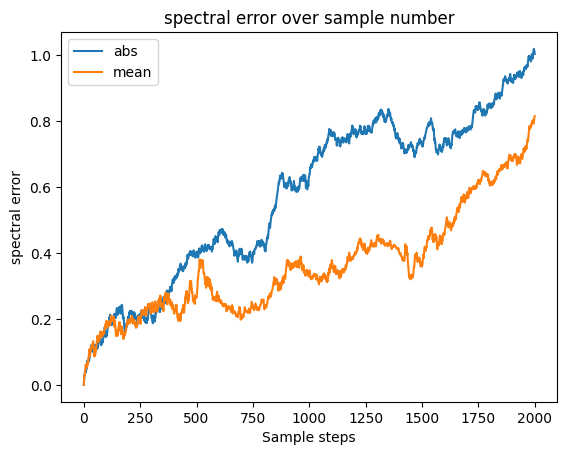

In [13]:
gen_sys_param(n=3,sample_steps=2000)
Ur = U_drift(drift_time_evolution.circuit.get_unitary(), seg, n_qdrift_steps, t_max, s[0], s[1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, Uexc,U,Uo, labels=['abs','mean'])

In [14]:
gen_sys_param(n=3,sample_steps = 1000)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps,seg)
particle_no_orig, idx_orig = drift_time_evolution_orig.Drift_exp(abs_coeff=False)

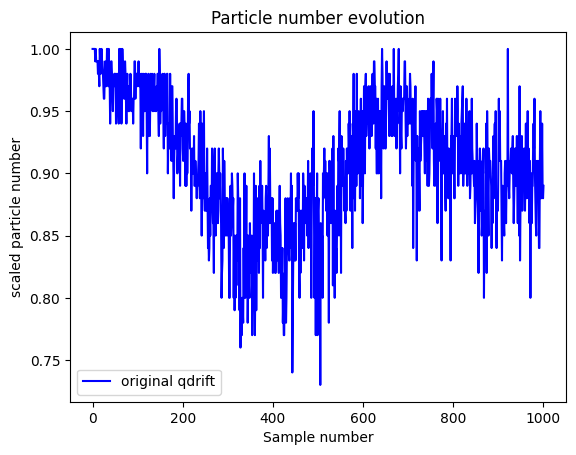

In [15]:
particle_number(sample_space,particle_no_orig, label='original qdrift', color='b')

In [17]:
gen_sys_param(n=3,sample_steps = 10)
drift_time_evolution_orig = AlgorithmHamSimqDrift(initial_state_circ,H_ops,H_coeff,t_max,n_qdrift_steps,seg)
particle_no_orig, idx_orig = drift_time_evolution_orig.Drift_exp(abs_coeff=False)

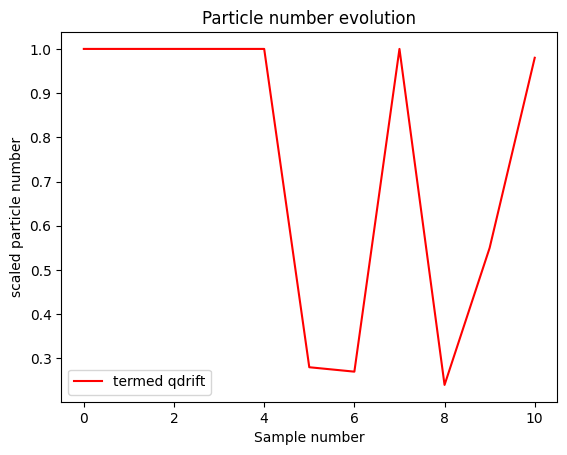

In [18]:
particle_number(sample_space,particle_no_orig, label='termed qdrift', color='r')

# Transformation

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()

/usr/local/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
# from qiskit_nature.second_q.mappers import JordanWignerMapper
# mapper = JordanWignerMapper()
# qubit_jw_op = mapper.map(fermionic_op)
# print(qubit_jw_op)

In [ ]:
H_matrix, ops_dict, ops2, H_ops_orig, H_coeff_orig = generate_dict(H())
H_matrix_r, ops_dict_r, ops2_r, H_ops_orig_r, H_coeff_orig_r = generate_dict(H_reduce())

In [ ]:
from qiskit_nature.second_q.mappers import ParityMapper
mapper = ParityMapper(num_particles=problem.num_particles)
qubit_op = mapper.map(fermionic_op)
print(qubit_op)

-1.0523732457728596 * II
+ 0.3979374248431793 * IZ
- 0.3979374248431793 * ZI
- 0.011280104256235213 * ZZ
+ 0.18093119978423136 * XX


/usr/local/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [ ]:
mapper_orig = ParityMapper()
qubit_op_orig = mapper_orig.map(fermionic_op)
print(qubit_op_orig)

-0.8105479805373275 * IIII
+ 0.1721839326191553 * IIIZ
- 0.22575349222402408 * IIZZ
+ 0.17218393261915538 * IZZI
- 0.22575349222402405 * ZZII
+ 0.12091263261776633 * IIZI
+ 0.16892753870087915 * IZZZ
+ 0.045232799946057854 * ZXIX
- 0.045232799946057854 * IXZX
- 0.045232799946057854 * ZXZX
+ 0.045232799946057854 * IXIX
+ 0.1661454325638242 * ZZIZ
+ 0.1661454325638242 * IZIZ
+ 0.17464343068300445 * ZZZZ
+ 0.12091263261776633 * ZIZI


In [ ]:
gen_sys_param(n=2,sample_steps=300)
drift_time_evolution_r = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig_r,H_coeff_orig_r,t_max,n_qdrift_steps)
particle_no_r, idx_r = drift_time_evolution_r.Drift_exp(track_no_paulistr=True)

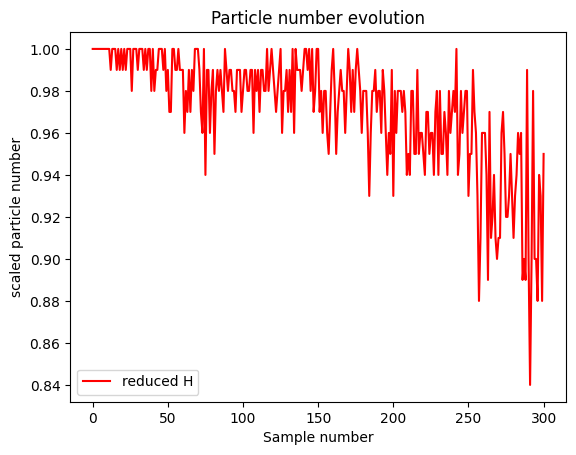

In [ ]:
particle_number(sample_space ,particle_no_r, label='reduced H', color='r')

In [ ]:
gen_sys_param(n=4,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps)
particle_no, idx = drift_time_evolution.Drift_exp(track_no_paulistr=True)

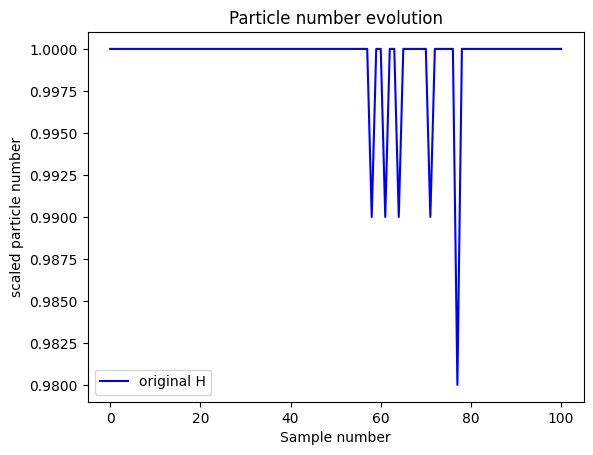

In [ ]:
particle_number(sample_space ,particle_no, label='original H', color='b')

# Exact particle group

In [30]:
driver = PySCFDriver_custom()
driver.load_molecule(
    atom=[("H", [-0.02111417,0.8350417,1.47688078]),  # H stands for hydrogen element in water
          ("O", [0.0, 0.0, 0.0]),                     # O stands for oxygen element in water
          ("H", [-0.00201087,0.45191737,-0.27300254])],         # Geometry of H2O molecule
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=2,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, excitation, no_excitation, double_excitation = JW_transformation(operator)

converged SCF energy = -74.0114684315929


In [ ]:
# from openfermion import jordan_wigner
# jordan_wigner(operator)

In [31]:
number_op, number_co = convert_op_to_input(number,n_qubits)
excitation_op, excitation_co = convert_op_to_input(excitation,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

In [32]:
print(excitation_op)

['XZXIIIIIIIIIII', 'YZYIIIIIIIIIII', 'XZZZXIIIIIIIII', 'YZZZYIIIIIIIII', 'XZZZZZXIIIIIII', 'YZZZZZYIIIIIII', 'XZZZZZZZZZXIII', 'YZZZZZZZZZYIII', 'XZZZZZZZZZZZXI', 'YZZZZZZZZZZZYI', 'IXZXIIIIIIIIII', 'IYZYIIIIIIIIII', 'IXZZZXIIIIIIII', 'IYZZZYIIIIIIII', 'IXZZZZZXIIIIII', 'IYZZZZZYIIIIII', 'IXZZZZZZZZZXII', 'IYZZZZZZZZZYII', 'IXZZZZZZZZZZZX', 'IYZZZZZZZZZZZY', 'IIXZXIIIIIIIII', 'IIYZYIIIIIIIII', 'IIXZZZXIIIIIII', 'IIYZZZYIIIIIII', 'IIXZZZZZZZXIII', 'IIYZZZZZZZYIII', 'IIXZZZZZZZZZXI', 'IIYZZZZZZZZZYI', 'IIIXZXIIIIIIII', 'IIIYZYIIIIIIII', 'IIIXZZZXIIIIII', 'IIIYZZZYIIIIII', 'IIIXZZZZZZZXII', 'IIIYZZZZZZZYII', 'IIIXZZZZZZZZZX', 'IIIYZZZZZZZZZY', 'IIIIXZXIIIIIII', 'IIIIYZYIIIIIII', 'IIIIXZZZZZXIII', 'IIIIYZZZZZYIII', 'IIIIXZZZZZZZXI', 'IIIIYZZZZZZZYI', 'IIIIIXZXIIIIII', 'IIIIIYZYIIIIII', 'IIIIIXZZZZZXII', 'IIIIIYZZZZZYII', 'IIIIIXZZZZZZZX', 'IIIIIYZZZZZZZY', 'IIIIIIXZZZXIII', 'IIIIIIYZZZYIII', 'IIIIIIXZZZZZXI', 'IIIIIIYZZZZZYI', 'IIIIIIIXZZZXII', 'IIIIIIIYZZZYII', 'IIIIIIIXZZZZZX', 'IIIIIIIY

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=30)
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[number_op,coulomb_op,excitation_op,no_excitation_op,double_excitation_op],[number_co,coulomb_co,excitation_co,no_excitation_co,double_excitation_co],t_max,n_qdrift_steps)
particle_no_p, idx_p, p = drift_time_evolution_parity.Drift_exp(track_no_paulistr=True)

In [ ]:
print(idx_p, p)

[0 0 0 0 0 1 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] [0.9186694014688874, 0.027498295093601778, 0.02632532078079732, 0.027498295093601778, 8.687563111640384e-06]


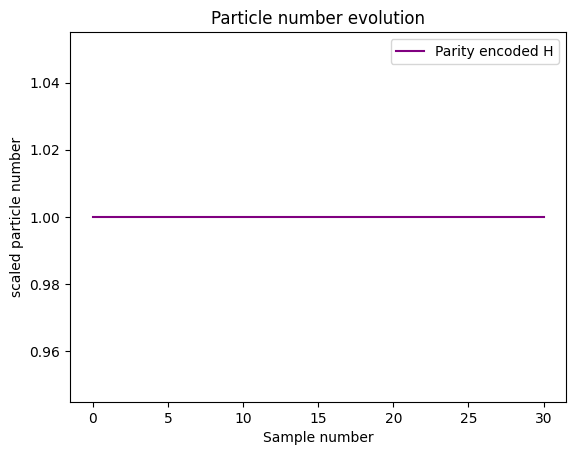

In [ ]:
particle_number(sample_space ,particle_no_p, label='Parity encoded H', color='purple')

# Symmetric protection

In [2]:
H_matrix, H_ops_orig, H_coeff_orig, H_ops, H_coeff = Heisenberg(5,1)

In [3]:
H_op = [['ZZIII',
  'IZZII',
  'IIZZI',
  'IIIZZ',
  'ZIIIZ',
  'ZIIII',
  'IZIII',
  'IIZII',
  'IIIZI',
  'IIIIZ'],
  ['XXIII', 'IXXII', 'IIXXI', 'IIIXX', 'XIIIX',
  'YYIII', 'IYYII', 'IIYYI', 'IIIYY', 'YIIIY']]
# H_co = [-0.5, -0.5, -0.5, -0.5, -0.5, 1.1, 0.8, 1.4, 1, 0.4,
#  -0.5, -0.5, -0.5, -0.5, -0.5,
#  -0.5, -0.5, -0.5, -0.5, -0.5]
H_co = [[1],[1]]

In [14]:
gen_sys_param(n=5,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_op,H_co,t_max,n_qdrift_steps,seg)
Us, ss = drift_time_evolution.Drift_exp(spectral=True, abs_coeff=False, trotter=True)

In [15]:
gen_sys_param(n=5,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_op,H_co,t_max,n_qdrift_steps,seg)
Uo, _ = drift_time_evolution.Drift_exp(sampled=ss, track_no_paulistr=True, spectral=True, abs_coeff=False)

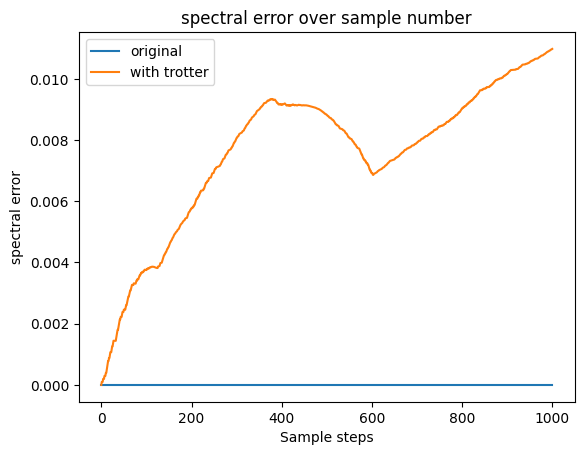

In [20]:
gen_sys_param(n=5,sample_steps=1000)
compare_spectral_error(sample_space, Uo,Uo,Us, labels=['original','with trotter'])

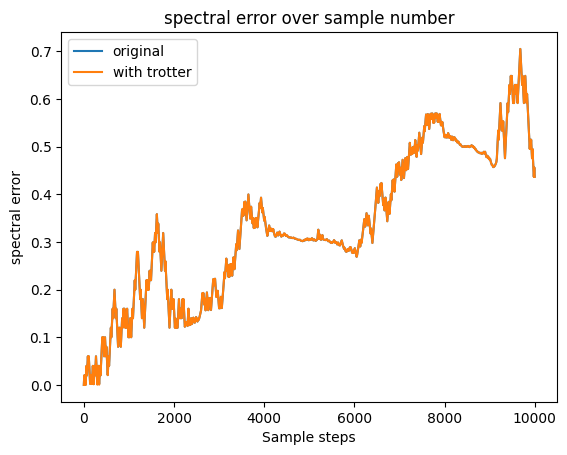

In [18]:
gen_sys_param(n=5,sample_steps=10000)
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, Uexc,Uo,Us, labels=['original','with trotter'], grouped=[10,10])

In [3]:
gen_sys_param(n=5,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps,seg)
Ut = drift_time_evolution.trotter()

In [5]:
gen_sys_param(n=5,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps,seg)
U2 = drift_time_evolution.trotter(order=2)

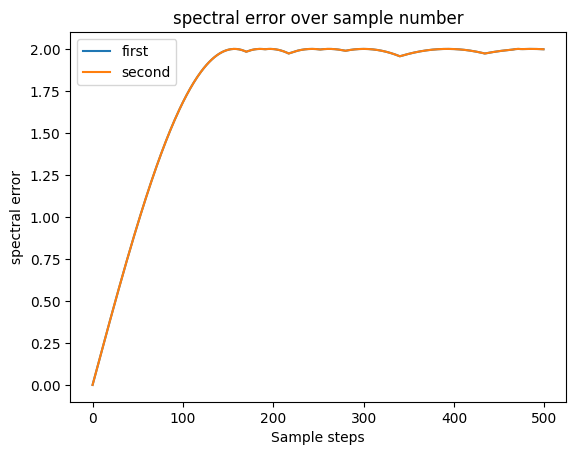

In [20]:
def U_trotter(init, n, t_max, H_matrix):
    t_step = t_max/(n//2)
    U_mat = ssl.expm(-1j * H_matrix * t_step).toarray()
    # print(U_mat.shape)
    evol = [ matrix_power(U_mat,i)@init for i in range(n+1) ]
    return evol

gen_sys_param(n=5,sample_steps=1000)
Uexc = U_trotter(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps, t_max, H_matrix)
compare_spectral_error((sample_space[0::2]/2)[:-1], Uexc,Ut,U2, labels=['first','second'])

In [9]:
gen_sys_param(n=5,sample_steps=drift_time_evolution.terms)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,H_ops_orig,H_coeff_orig,t_max,n_qdrift_steps, seg)
U,s = drift_time_evolution.Drift_exp(spectral=True,abs_coeff=False)

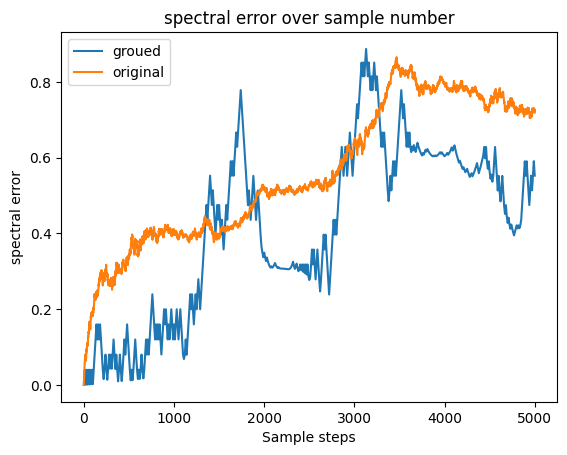

In [14]:
gen_sys_param(n=5,sample_steps=5000)
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, Uexc,Uo,U, labels=['grouped','original'], grouped=10)

In [ ]:
n_trotter_steps = 50
gen_sys_param()
trotter_time_evolution2 = AlgorithmHamSimTrotter(initial_state_circ,Heisenberg[0],measurements,t_max,n_trotter_steps,t)
trotter_time_evolution2.lie_trotter()
U_sim, U = trotter_time_evolution2.execute(labels=['LieTrotter','LieTrotter','LieTrotter'], color='red', cheat=False, plot=False)
# print(np.around(U_sim,2)- np.around(U,2))

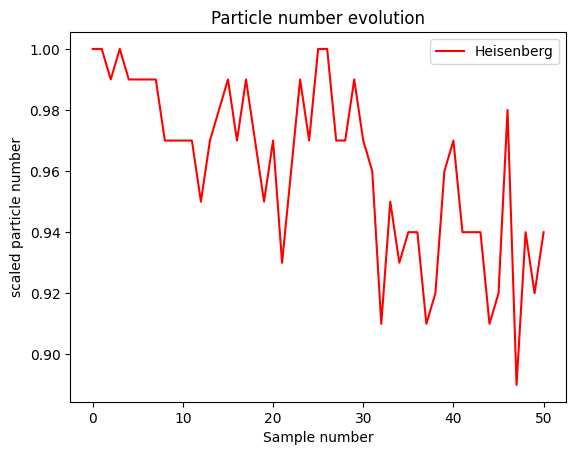

In [6]:
particle_number(sample_space ,particle_no, label='Heisenberg', color='r')

In [24]:
gen_sys_param(n=5,sample_steps=10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[[H] for H in H_op],[[h] for h in H_co],t_max,n_qdrift_steps, seg)
particle_no, samples = drift_time_evolution.Drift_exp(abs_coeff=False)

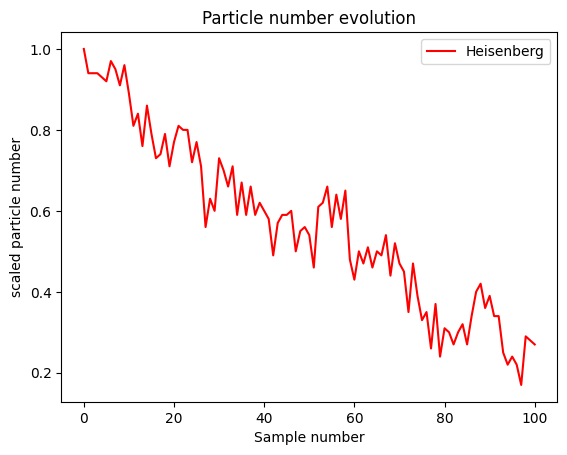

In [25]:
particle_number(sample_space ,particle_no, label='Heisenberg', color='r')

In [26]:
gen_sys_param(n=5,sample_steps=100)
drift_time_evolution_s = AlgorithmHamSimqDrift(initial_state_circ,[[H] for H in H_op],[[h] for h in H_co],t_max,n_qdrift_steps,seg)
particle_no_r, _ = drift_time_evolution_s.Drift_exp(sampled=samples, protected=True, abs_coeff=False)

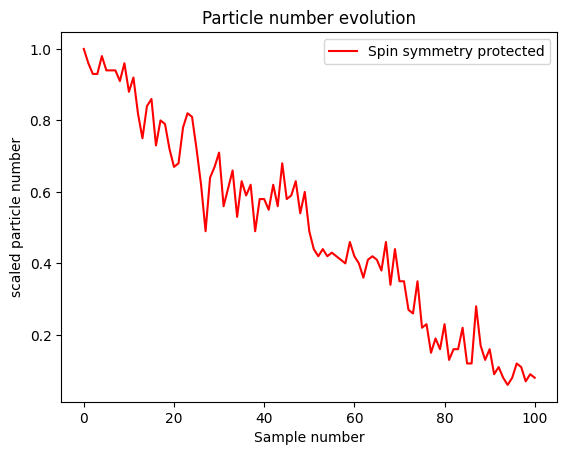

In [28]:
particle_number(sample_space ,particle_no_r, label='Spin symmetry protected', color='r')

In [33]:
from openfermion import QubitOperator as q
from openfermion import get_sparse_operator
from utils.term_grouping import get_openfermion_str
Hq = q()

cirq_ops = []
for op in H_op:
    cirq_ops.append(get_openfermion_str(op))

for co, op in zip(H_co, cirq_ops):
    Hq += q(op, co)

H_matrix = get_sparse_operator(Hq)


In [34]:
gen_sys_param(n=5,sample_steps=100)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[[H] for H in H_op],[[h] for h in H_co],t_max,n_qdrift_steps)
Us, s = drift_time_evolution.Drift_exp(spectral=True,sampled=samples)

In [35]:
gen_sys_param(n=5,sample_steps=100)
drift_time_evolution_s = AlgorithmHamSimqDrift(initial_state_circ,[[H] for H in H_op],[[h] for h in H_co],t_max,n_qdrift_steps)
U, _ = drift_time_evolution.Drift_exp(spectral=True,protected=True,sampled=samples)

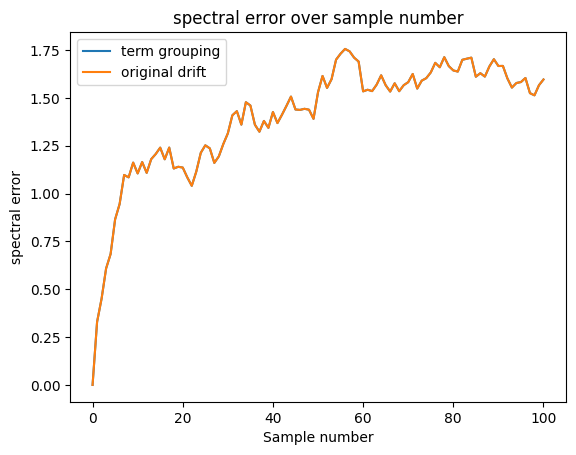

In [36]:
gen_sys_param(n=5,sample_steps =100)
Ur = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps, t_max, H_matrix)
compare_spectral_error(sample_space, Ur, Us, U)

# Hydrogen chain

In [59]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    # atom = [("H", [-0.02111417,0.8350417,1.47688078]),  # H stands for hydrogen element in water
    #         ("O", [0.0, 0.0, 0.0])],
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
print(n_qubits)
number, coulomb, excitation, no_excitation, double_excitation = JW_transformation(operator)

converged SCF energy = -1.52399620024611
6


In [60]:
number_op, number_co = convert_op_to_input(number,n_qubits)
excitation_op, excitation_co = convert_op_to_input(excitation,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)

In [37]:
print(number_op,number_co)

['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ'] [0.9359065868301966, 0.9359065868301966, 0.7517644114889679, 0.7517644114889679, 0.6045486382025314, 0.6045486382025314, 0.4767243486881735, 0.4767243486881735]


In [46]:
print(excitation_op,excitation_co)

['XZXIIIIIIIII', 'YZYIIIIIIIII', 'XZZZZZXIIIII', 'YZZZZZYIIIII', 'XZZZZZZZZZXI', 'YZZZZZZZZZYI', 'IXZXIIIIIIII', 'IYZYIIIIIIII', 'IXZZZZZXIIII', 'IYZZZZZYIIII', 'IXZZZZZZZZZX', 'IYZZZZZZZZZY', 'IIXZZZXIIIII', 'IIYZZZYIIIII', 'IIXZZZZZZZXI', 'IIYZZZZZZZYI', 'IIIXZZZXIIII', 'IIIYZZZYIIII', 'IIIXZZZZZZZX', 'IIIYZZZZZZZY', 'IIIIIIXZZZXI', 'IIIIIIYZZZYI', 'IIIIIIIXZZZX', 'IIIIIIIYZZZY'] [0.3062796158617642, 0.3062796158617642, -0.034019251169979725, -0.034019251169979725, -0.03702386258043894, -0.03702386258043894, 0.3062796158617642, 0.3062796158617642, -0.034019251169979725, -0.034019251169979725, -0.03702386258043894, -0.03702386258043894, 0.14591492413115142, 0.14591492413115142, 0.20553281388806877, 0.20553281388806877, 0.14591492413115142, 0.14591492413115142, 0.20553281388806877, 0.20553281388806877, 0.9613370805383197, 0.9613370805383197, 0.9613370805383197, 0.9613370805383197]


In [61]:
print(len(double_excitation_op))

40


In [4]:
max_part_group = [[number_op[0], number_op[-2], excitation_op[0], excitation_op[1]],number_op[2:4],[number_op[1], number_op[-1], excitation_op[-2],excitation_op[-1]]]
max_coeff = [[(number_co[0]+number_co[-2]+abs(excitation_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(excitation_co[0])*2)/4]]

In [7]:
gen_sys_param(n=n_qubits,sample_steps=20)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
Ut,ldepth = drift_time_evolution.trotter(protected=False)

In [5]:
gen_sys_param(n=n_qubits,sample_steps=10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
U2p,secdepth = drift_time_evolution.trotter(order=2)

In [8]:
gen_sys_param(n=n_qubits,sample_steps=10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+excitation_op,number_co+excitation_co,t_max,n_qdrift_steps, seg)
U2,secdepth = drift_time_evolution.trotter(order=2,protected=False)

In [13]:
def take_id(U,sample):
    U_new = []
    for i in range(len(sample)):
        U_new.append(U[sample[i]])
    return U_new

In [14]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

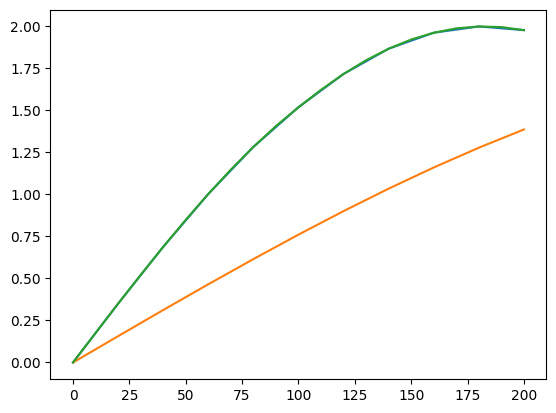

In [15]:
plt.plot(secdepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(U2,take_id(Uexc,secdepth))])
plt.plot(secdepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(U2p,take_id(Uexc,ldepth))])
plt.plot(ldepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Ut,take_id(Uexc,ldepth))])

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,max_part_group,max_coeff,t_max,n_qdrift_steps, seg)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=1000)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[number_op,excitation_op],[number_co,excitation_co],t_max,n_qdrift_steps, seg)
Ug,sg,gdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])

In [ ]:
gen_sys_param(n=n_qubits,sample_steps=1000)
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+excitation_op],[[c] for c in number_co+excitation_co],t_max,n_qdrift_steps,seg)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1])

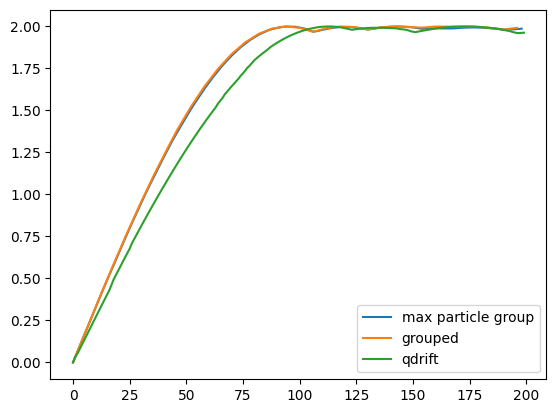

In [17]:
plt.plot(mdepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Um,take_id(Uexc,mdepth))],label='max particle group')
plt.plot(gdepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Ug,take_id(Uexc,gdepth))],label='grouped')
plt.plot(qdepth,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Uq,take_id(Uexc,qdepth))],label='qdrift')
plt.legend()

In [10]:
from openfermion import QubitOperator as q
from openfermion import get_sparse_operator
from utils.term_grouping import get_openfermion_str
Hq = q()

cirq_ops = []
for op in number_op+excitation_op:
    cirq_ops.append(get_openfermion_str(op,n=n_qubits))

for co, op in zip(number_co+excitation_co, cirq_ops):
    Hq += q(op, co)

H_matrix = get_sparse_operator(Hq)


In [ ]:
import numpy as np

def inverse_transform_sampling(weights, num_samples):
    cumulative_weights = np.cumsum(weights)
    cumulative_weights /= cumulative_weights[-1]  # Normalize to [0, 1]

    uniform_samples = np.random.rand(num_samples)
    indices = np.searchsorted(cumulative_weights, uniform_samples)

    return indices

# Weighted distribution
weights = np.array([1, 2, 3, 4, 3, 2, 1])  # Example weights

# Number of samples to generate
num_samples = 1000

# Convert to normal-like samples using inverse transform sampling
sample_indices = inverse_transform_sampling(weights, num_samples)

# Generate normal samples using the indices
normal_samples = np.random.randn(num_samples) + sample_indices

print("Generated normal-like samples:")
print(normal_samples)


In [9]:
def comp(sample_number, U, Us, Us_orig, labels, Us_prot=None, sample=None):
    plt.plot(cumulative_len(sample),[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Us,take_idx(U,sample))], label=labels[0])
    plt.plot(sample_number,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Us_orig,U)], label=labels[1])
    plt.plot(cumulative_len(sample),[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(Us_prot,take_idx(U,sample))], label=labels[2])     
    plt.title('spectral error over sample number')
    plt.xlabel('Sample steps')
    plt.ylabel('spectral error') 
    plt.legend()

In [8]:
def cumulative_len(s):
    count = [0]
    for i in range(len(s)):
        count.append(count[-1]+len(s[i]))
    return count

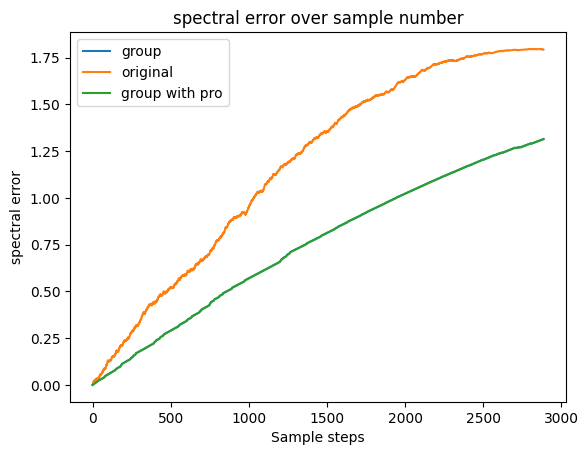

In [18]:
comp(np.arange(drift_time_evolution.terms+1), Uexc, U, Us, labels=['group','original','group with pro'],  Us_prot=Up, sample=s[0])

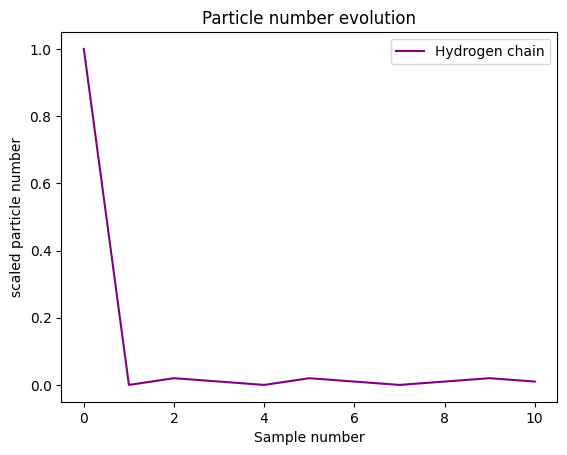

In [ ]:
particle_number(sample_space ,particle_no_h, label='Hydrogen chain', color='purple')